# Réseaux à convolution

Dans ce notebook, nous crérons un réseau à convolution.  Mais avant de commencer, assurez-vous d'avoir bien compris les notebooks sur la **convolution**, la **batch-norm** et le **dropout**.

Ici, nous utiliserons pour l'essentiel le code dans les fichiers suivants :

    model/Model.py
    layers/Conv.py 
    utils/model_loss.py
    layers/MaxPool.py
    
Comme au tp1 et dans les notebook précédents, la classe **Model** "crée" un réseau de neurones en ajoutant successivement des couches et une fonction de perte.

Attention, pas de plagiat! votre code de convolution naïve de la classe **Conv2DNaive** doit être radicalement différent de celui des classes **Conv2DMat** et **Conv2DCython**.


In [1]:
import random
import numpy as np
from utils.data_utils import load_CIFAR10
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Pour automatiquement recharger les modules externes
# voir http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
def create_toy_data():
    np.random.seed(1)
    X = 10 * np.random.randn(num_inputs, channels, input_size, input_size)
    y = np.array([0, 1, 2, 1, 2])
    return X, y

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Charger la banque de données CIFAR-10, prétraiter les images et ajouter une dimension pour le biais.
    
    Input :
    - num_training : nombre d'images à mettre dans l'ensemble d'entrainement
    - num_validation : nombre d'images à mettre dans l'ensemble de validation
    - num_test : nombre d'images à mettre dans l'ensemble de test
    - num_dev : d'images à mettre dans l'ensemble dev
    
    Output :
    - X_train, y_train : données et cibles d'entrainement
    - X_val, y_val: données et cibles de validation
    - X_test y_test: données et cibles de test 
    - X_dev, y_dev: données et cicles dev
    """
    # Charger les données CIFAR-10
    cifar10_dir = 'datasets/cifar-10-batches-py'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
  
    # Séparer en ensembles d'entraînement, de validation, de test et de dev
    mask = range(num_training, num_training + num_validation)
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = range(num_training)
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = range(num_test)
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    
    X_train = X_train.transpose(0, 3, 1, 2)
    X_test = X_test.transpose(0, 3, 1, 2)
    X_val = X_val.transpose(0, 3, 1, 2)
    X_dev = X_dev.transpose(0, 3, 1, 2)

    # Normalisation
    X_train -= np.mean(X_train, axis = 0)
    X_val -= np.mean(X_val, axis = 0)
    X_test -= np.mean(X_test, axis = 0)
    X_dev -= np.mean(X_dev, axis = 0)

    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev

## Modèle simple

Commençons avec un modèle très simple à une couche cachée.  Pour la fonction:

    cross_entropy_loss
    
vous pouvez récupérer votre code du tp1


In [3]:
from model.Model import Model
from layers.Conv import Conv2DNaive
from utils.model_loss import cross_entropy_loss

num_filters = 3
filter_size = 4
channels = 1
num_inputs = 5
input_size = 4
padding = 0
stride = 1

np.random.seed(0)
model = Model()
layer = Conv2DNaive(num_filters, filter_size=filter_size, channels=channels, 
                        stride=stride, padding=padding, weight_scale=1e-1)
model.add(layer)
model.add_loss(cross_entropy_loss)

In [4]:
##############################################################################
# TODO: Récupérez le code "naïf" de la convolution que vous avez fait dans   #
#   le notebook sur la convolution et le mettre dans la fonction "forward"   #
#   de la classe Conv2DNaive dans le fichier Conv.py.                        #
#   S'il n'y a pas de bug, le test suivant devrait passer                    #
##############################################################################
X, y = create_toy_data()
scores = model.forward(X).reshape(num_inputs, num_filters)
correct_scores = np.asarray([[2.26107191, 1.90356006, -10.7996371 ],
                             [-4.03277981, 6.72254124, 0.36232013],
                             [-0.33115169, 3.30740614, 8.24078811],
                             [-0.78558615, 3.5691293, -5.41204248],
                             [7.16759091, -7.01187203, -4.51633761]])

print('Your scores:')
print(scores)
print()
print('correct scores:')
print(correct_scores)
print()

# La différence devrait être assez basse, en principe inférieure à 1e-7.
print('Difference between your scores and correct scores: ', np.sum(np.abs(scores - correct_scores)))

Your scores:
[[  2.26107191   1.90356006 -10.7996371 ]
 [ -4.03277981   6.72254124   0.36232013]
 [ -0.33115169   3.30740614   8.24078811]
 [ -0.78558615   3.5691293   -5.41204248]
 [  7.16759091  -7.01187203  -4.51633761]]

correct scores:
[[  2.26107191   1.90356006 -10.7996371 ]
 [ -4.03277981   6.72254124   0.36232013]
 [ -0.33115169   3.30740614   8.24078811]
 [ -0.78558615   3.5691293   -5.41204248]
 [  7.16759091  -7.01187203  -4.51633761]]

Difference between your scores and correct scores:  3.1734064542821017e-08


In [5]:
loss, dScores, _ = model.calculate_loss(scores, y, 0.1)
correct_loss = 2.47808382744825

# on devrait obtenir une erreur inférieure à environ 1e-12.
print('Loss: ', loss)
print('Correct loss: ', correct_loss)
print('Difference between your loss and correct loss: ', np.sum(np.abs(loss - correct_loss)))

Loss:  2.478083827448259
Correct loss:  2.47808382744825
Difference between your loss and correct loss:  8.881784197001252e-15


# BONUS 0.5 Point

Coder la rétro-progagation naïve (fonction **backward** de la classe **Conv2DNaive** dans le fichier **layers/Conv.py**).  Attention, pas de plagiat! votre code doit être significativement différent de celui des classes **Conv2DMat** et **Conv2DCython**.

In [6]:
##############################################################################
# TODO: Implémenter la méthode backward (rétro-propagation) de la classe de  #
# couche Conv2DNaive.                                                        #
##############################################################################

_ = model.backward(dScores.reshape(5, 3, 1, 1))

In [7]:
from utils.gradients import evaluate_numerical_gradient

# Retourne l'erreur relative maximale des matrices de gradients passées en paramètre.
# Pour chaque paramètre, l'erreur relative devrait être inférieure à environ 1e-8.
def rel_error(x, y):
    rel = np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y)))
    return np.max(rel)

gradients = model.gradients()
model_params = model.parameters()

for layer_name, layer_params in model_params.items():
    for param_name, _ in layer_params.items():
        grad_num = evaluate_numerical_gradient(X, y, model, layer_name, param_name, reg=0.1)
        max_error = rel_error(grad_num, gradients[layer_name][param_name])
        
        print('%s max relative error: %e' % (layer_name + '-' + param_name, max_error))

L0-W max relative error: 9.504080e-10
L0-b max relative error: 8.742849e-11


# Test de différentes implantations de la convolution

    version naive
    version "matricée"
    version "optimisée"

La version optimisée implique l'utilisation de code **"cython"** que vous devez compiler (voir README.md)


In [8]:
from model.Model import Model
from layers.Conv import Conv2DNaive, Conv2DMat, Conv2DCython
from utils.model_loss import cross_entropy_loss

num_filters = 3
filter_size = 4
channels = 1

num_inputs = 5
input_size = 4
padding = 0
stride = 1

def create_toy_model():
    np.random.seed(0)
    model = Model()
    layer = Conv2DNaive(num_filters, filter_size=filter_size, channels=channels, 
                        stride=stride, padding=padding, weight_scale=1e-1)
    model.add(layer)
    model.add_loss(cross_entropy_loss)
    return model

def create_toy_model_mat():
    np.random.seed(0)
    model = Model()
    layer = Conv2DMat(num_filters, filter_size=filter_size, channels=channels, 
                      stride=stride, padding=padding, weight_scale=1e-1)
    model.add(layer)
    model.add_loss(cross_entropy_loss)
    return model

def create_toy_model_fast():
    np.random.seed(0)
    model = Model()
    layer = Conv2DCython(num_filters, filter_size=filter_size, channels=channels, 
                         stride=stride, padding=padding, weight_scale=1e-1)
    model.add(layer)
    model.add_loss(cross_entropy_loss)
    return model

model_naive = create_toy_model()
model_mat = create_toy_model_mat()
model_fast = create_toy_model_fast()
X, y = create_toy_data()

<font size="4">CNN avec matricisation des entrées</font>

Ici le code "forward" et "backward" de la convolution "matricée" vous est fourni... à un détail prêt:  **il manque la fonction d'activation dans la propagation avant**.  À vous de l'ajouter à la fonction "forward" (c.f. classe **Conv2DMat**)


In [9]:
##############################################################################
# TODO: Implémenter la méthode forward (propagation avant) de la classe de   #
# couche Conv2DMat (convolution matricisée).                                 #
##############################################################################

scores = model_mat.forward(X).reshape(num_inputs, num_filters)
correct_scores = np.asarray([[2.26107191, 1.90356006, -10.7996371 ],
                             [-4.03277981, 6.72254124, 0.36232013],
                             [-0.33115169, 3.30740614, 8.24078811],
                             [-0.78558615, 3.5691293, -5.41204248],
                             [7.16759091, -7.01187203, -4.51633761]])

print('Your scores:')
print(scores)
print()
print('correct scores:')
print(correct_scores)
print()

# La différence devrait être assez basse, en principe inférieure à 1e-7.
print('Difference between your scores and correct scores: ', np.sum(np.abs(scores - correct_scores)))

Your scores:
[[  2.26107191   1.90356006 -10.7996371 ]
 [ -4.03277981   6.72254124   0.36232013]
 [ -0.33115169   3.30740614   8.24078811]
 [ -0.78558615   3.5691293   -5.41204248]
 [  7.16759091  -7.01187203  -4.51633761]]

correct scores:
[[  2.26107191   1.90356006 -10.7996371 ]
 [ -4.03277981   6.72254124   0.36232013]
 [ -0.33115169   3.30740614   8.24078811]
 [ -0.78558615   3.5691293   -5.41204248]
 [  7.16759091  -7.01187203  -4.51633761]]

Difference between your scores and correct scores:  3.1734065319977134e-08


In [10]:
loss, dScores_mat, _ = model_mat.calculate_loss(scores, y, 0.1)
correct_loss = 2.47808382744825

# on devrait obtenir une erreur  inférieure à environ 1e-12.
print('Loss: ', loss)
print('Correct loss: ', correct_loss)
print('Difference between your loss and correct loss: ', np.sum(np.abs(loss - correct_loss)))

Loss:  2.478083827448259
Correct loss:  2.47808382744825
Difference between your loss and correct loss:  8.881784197001252e-15


In [11]:
##############################################################################
# Normalement cette ligne devrait fonctionner car le code est donnée         #
##############################################################################

_ = model_mat.backward(dScores_mat.reshape(5, 3, 1, 1))

In [12]:
gradients = model_mat.gradients()
model_params = model_mat.parameters()

for layer_name, layer_params in model_params.items():
    for param_name, _ in layer_params.items():
        grad_num = evaluate_numerical_gradient(X, y, model_mat, layer_name, param_name, reg=0.1)
        max_error = rel_error(grad_num, gradients[layer_name][param_name])
        
        print('%s max relative error: %e' % (layer_name + '-' + param_name, max_error))

L0-W max relative error: 9.504063e-10
L0-b max relative error: 5.135058e-11


<font size="4">CNN vectorisé, utilise cython</font>

Ici le code "forward" et "backward" de la convolution "cythonisée" vous est fourni... à un détail prêt:  **il manque la fonction d'activation dans la propagation avant**.  À vous de l'ajouter à la fonction "forward" (c.f. classe **Conv2DCython**).

In [13]:
##############################################################################
# TODO: Implémenter la méthode forward (propagation avant) de la classe de   #
# couche Conv2DCython.                                                       #
##############################################################################

scores = model_fast.forward(X).reshape(num_inputs, num_filters)
correct_scores = np.asarray([[2.26107191, 1.90356006, -10.7996371 ],
                             [-4.03277981, 6.72254124, 0.36232013],
                             [-0.33115169, 3.30740614, 8.24078811],
                             [-0.78558615, 3.5691293, -5.41204248],
                             [7.16759091, -7.01187203, -4.51633761]])

print('Your scores:')
print(scores)
print()
print('correct scores:')
print(correct_scores)
print()

# La différence devrait être assez basse, en principe inférieure à 1e-7.
print('Difference between your scores and correct scores: ', np.sum(np.abs(scores - correct_scores)))

Your scores:
[[  2.26107191   1.90356006 -10.7996371 ]
 [ -4.03277981   6.72254124   0.36232013]
 [ -0.33115169   3.30740614   8.24078811]
 [ -0.78558615   3.5691293   -5.41204248]
 [  7.16759091  -7.01187203  -4.51633761]]

correct scores:
[[  2.26107191   1.90356006 -10.7996371 ]
 [ -4.03277981   6.72254124   0.36232013]
 [ -0.33115169   3.30740614   8.24078811]
 [ -0.78558615   3.5691293   -5.41204248]
 [  7.16759091  -7.01187203  -4.51633761]]

Difference between your scores and correct scores:  3.17340637656649e-08


In [14]:
loss, dScores_fast, _ = model_fast.calculate_loss(scores, y, 0.1)
correct_loss = 2.47808382744825

# on devrait obtenir une erreur  inférieure à environ 1e-12.
print('Loss: ', loss)
print('Correct loss: ', correct_loss)
print('Difference between your loss and correct loss: ', np.sum(np.abs(loss - correct_loss)))

Loss:  2.478083827448259
Correct loss:  2.47808382744825
Difference between your loss and correct loss:  8.881784197001252e-15


In [15]:
##############################################################################
# Normalement cette ligne devrait fonctionner car le code est donnée         #
##############################################################################

_ = model_fast.backward(dScores_fast.reshape(5, 3, 1, 1))

In [16]:
gradients = model_fast.gradients()
model_params = model_fast.parameters()

# L'erreur devrait être inférieure à 1e-5
for layer_name, layer_params in model_params.items():
    for param_name, _ in layer_params.items():
        grad_num = evaluate_numerical_gradient(X, y, model_fast, layer_name, param_name, reg=0.1)
        max_error = rel_error(grad_num, gradients[layer_name][param_name])
        
        print('%s max relative error: %e' % (layer_name + '-' + param_name, max_error))

L0-W max relative error: 9.625145e-10
L0-b max relative error: 8.742815e-11


<font size="4">Comparaison des performances</font>

Maintenant, voyons à quel point le type d'implantation d'une convolution peut avoir un impact sur la rapidité d'exécution.

<font size="3">Forward</font>

In [17]:
model_naive = create_toy_model()
model_mat = create_toy_model_mat()
model_fast = create_toy_model_fast()

In [18]:
print("version naive...")
%timeit model_naive.forward(X)
print("version matricée...")
%timeit model_mat.forward(X)
print("version rapide cythonisée...")
%timeit model_fast.forward(X)

version naive...
347 µs ± 9.38 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
version matricée...
181 µs ± 889 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
version rapide cythonisée...
153 µs ± 2.73 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


<font size="3">Rétro-propagation</font>

In [19]:
model_naive = create_toy_model()
model_mat = create_toy_model_mat()
model_fast = create_toy_model_fast()

In [20]:
scores_naive = model_naive.forward(X).reshape(num_inputs, num_filters)
loss_naive, dScores_naive, _ = model_naive.calculate_loss(scores, y, 0.1)

scores_mat = model_mat.forward(X).reshape(num_inputs, num_filters)
loss_mat, dScores_mat, _ = model_fast.calculate_loss(scores, y, 0.1)

scores_fast = model_fast.forward(X).reshape(num_inputs, num_filters)
loss_fast, dScores_fast, _ = model_fast.calculate_loss(scores, y, 0.1)

In [21]:
# En principe, les loss et des gradients devraient être les mêmes

if np.abs(loss_naive - loss_mat) + \
    np.abs(loss_naive - loss_fast) + \
    np.abs(loss_mat - loss_fast) > 1e-6:
    print("Erreur!")
else:
    print("Loss bonne!")    

if (np.abs(dScores_mat - dScores_naive)).flatten().mean() + \
    (np.abs(dScores_fast - dScores_naive)).flatten().mean() + \
    (np.abs(dScores_mat - dScores_fast)).flatten().mean() > 1e-6 :
    print("Erreur!")
else:
    print("Gradients bons!")    


Loss bonne!
Gradients bons!


In [22]:
print("version naive...")
%timeit _ = model.backward(dScores_naive.reshape(5, 3, 1, 1))
print("version matricée...")
%timeit _ = model_mat.backward(dScores_mat.reshape(5, 3, 1, 1))
print("version rapide cythonisée...")
%timeit _ = model_fast.backward(dScores_fast.reshape(5, 3, 1, 1))

version naive...
306 µs ± 21 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
version matricée...
218 µs ± 12.3 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
version rapide cythonisée...
64.3 µs ± 834 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


<font size="5">CNN à 2 couches</font>

Ici nous testerons des réseaux à 2 couches convolutives.  En principe, si le code des dernières cellules fonctionne, le code des prochaines cellules devrait fonctionner!


In [23]:
from model.Model import Model
from layers.Conv import Conv2DNaive, Conv2DMat, Conv2DCython
from utils.model_loss import cross_entropy_loss

num_filters = 4
filter_size = 3
channels = 2

num_inputs = 5
input_size = 5
padding = 1
stride = 2

num_classes = 3

def create_toy_model():
    np.random.seed(0)
    model = Model()
    layer0 = Conv2DNaive(num_filters, filter_size=filter_size, channels=channels, 
                         stride=stride, padding=padding, weight_scale=1e-1)
    layer1 = Conv2DNaive(num_classes, filter_size=3, channels=num_filters, 
                         weight_scale=1e-1)
    
    model.add(layer0)
    model.add(layer1)
    model.add_loss(cross_entropy_loss)
    return model

def create_toy_model_mat():
    np.random.seed(0)
    model = Model()
    layer0 = Conv2DMat(num_filters, filter_size=filter_size, channels=channels, 
                       stride=stride, padding=padding, weight_scale=1e-1)
    layer1 = Conv2DMat(num_classes, filter_size=3, channels=num_filters, 
                       weight_scale=1e-1)
    model.add(layer0)
    model.add(layer1)
    model.add_loss(cross_entropy_loss)
    return model

def create_toy_model_fast():
    np.random.seed(0)
    model = Model()
    layer0 = Conv2DCython(num_filters, filter_size=filter_size, channels=channels, 
                          stride=stride, padding=padding, weight_scale=1e-1)
    layer1 = Conv2DCython(num_classes, filter_size=3, channels=num_filters, 
                          weight_scale=1e-1)
    model.add(layer0)
    model.add(layer1)
    model.add_loss(cross_entropy_loss)
    return model

def create_toy_data():
    np.random.seed(1)
    X = 10 * np.random.randn(num_inputs, channels, input_size, input_size)
    y = np.array([0, 1, 2, 1, 2])
    return X, y

model_naive = create_toy_model()
model_mat = create_toy_model_mat()
model_fast = create_toy_model_fast()
X, y = create_toy_data()

In [24]:
scores_naive = model_naive.forward(X).reshape(num_inputs, num_classes)
loss_naive, dScores_naive, _ = model_naive.calculate_loss(scores_naive, y, 0.1)

scores_mat = model_mat.forward(X).reshape(num_inputs, num_classes)
loss_mat, dScores_mat, _ = model_mat.calculate_loss(scores_mat, y, 0.1)

scores_fast = model_fast.forward(X).reshape(num_inputs, num_classes)
loss_fast, dScores_fast, _ = model_fast.calculate_loss(scores_fast, y, 0.1)

In [25]:
# En principe, les loss et des gradients devraient être les mêmes

if np.abs(loss_naive - loss_mat) + \
    np.abs(loss_naive - loss_fast) + \
    np.abs(loss_mat - loss_fast) > 1e-6:
    print("Erreur!")
else:
    print("Loss bonne!")    

if (np.abs(dScores_mat - dScores_naive)).flatten().mean() + \
    (np.abs(dScores_fast - dScores_naive)).flatten().mean() + \
    (np.abs(dScores_mat - dScores_fast)).flatten().mean() > 1e-6 :
    print("Erreur!")
else:
    print("Gradients bons!")    


Loss bonne!
Gradients bons!


In [26]:
_ = model_naive.backward(dScores_naive.reshape(5, 3, 1, 1))
_ = model_mat.backward(dScores_mat.reshape(5, 3, 1, 1))
_ = model_fast.backward(dScores_fast.reshape(5, 3, 1, 1))

In [27]:
# Vérification du gradient pour le modèle naif, devrait être inférieur à 1e-4
gradients = model_naive.gradients()
model_params = model_naive.parameters()

for layer_name, layer_params in model_params.items():
    for param_name, _ in layer_params.items():
        grad_num = evaluate_numerical_gradient(X, y, model_naive, layer_name, param_name, reg=0.1)
        max_error = rel_error(grad_num, gradients[layer_name][param_name])
        
        print('%s max relative error: %e' % (layer_name + '-' + param_name, max_error))

L0-W max relative error: 2.629573e-09
L0-b max relative error: 4.003973e-10
L1-W max relative error: 9.194694e-10
L1-b max relative error: 7.874844e-09


In [28]:
# Gradient check pour le modèle matricisé, devrait être inférieur à 1e-4
gradients = model_mat.gradients()
model_params = model_mat.parameters()

for layer_name, layer_params in model_params.items():
    for param_name, _ in layer_params.items():
        grad_num = evaluate_numerical_gradient(X, y, model_mat, layer_name, param_name, reg=0.1)
        max_error = rel_error(grad_num, gradients[layer_name][param_name])
        
        print('%s max relative error: %e' % (layer_name + '-' + param_name, max_error))

L0-W max relative error: 2.629556e-09
L0-b max relative error: 4.003978e-10
L1-W max relative error: 1.315611e-09
L1-b max relative error: 7.874870e-09


In [29]:
# Gradient check pour le modèle cythonisé.
# Les valeurs peuvent être légèrement différentes de celles
# obtenues pour model_naive et model_mat (Effet de bord de Cython).
# En autant qu'elles restent inférieures à 1e-4, c'est correct.
gradients = model_fast.gradients()
model_params = model_fast.parameters()

for layer_name, layer_params in model_params.items():
    for param_name, _ in layer_params.items():
        grad_num = evaluate_numerical_gradient(X, y, model_fast, layer_name, param_name, reg=0.1)
        max_error = rel_error(grad_num, gradients[layer_name][param_name])
        
        print('%s max relative error: %e' % (layer_name + '-' + param_name, max_error))

L0-W max relative error: 2.629560e-09
L0-b max relative error: 1.938866e-10
L1-W max relative error: 1.315613e-09
L1-b max relative error: 2.627894e-09


<font size="4">Comparaison des performances</font>

<font size="3">Propagation avant</font>

les différentes implantation de convolution devraient entraîner divers temps d'exécution.

In [30]:
model_naive = create_toy_model()
model_mat = create_toy_model_mat()
model_fast = create_toy_model_fast()

In [31]:
print("CNN 2 couches, conv naive")
%timeit model_naive.forward(X)
print("CNN 2 couches, conv mat")
%timeit model_mat.forward(X)
print("CNN 2 couches, conv fast")
%timeit model_fast.forward(X)

CNN 2 couches, conv naive
3.27 ms ± 129 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
CNN 2 couches, conv mat
628 µs ± 30.6 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
CNN 2 couches, conv fast
322 µs ± 4.85 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


<font size="3">Rétro-propagation</font>

In [32]:
scores_naive = model_naive.forward(X).reshape(num_inputs, num_classes)
_, dScores_naive, _ = model_naive.calculate_loss(scores_naive, y, 0.1)

scores_mat = model_mat.forward(X).reshape(num_inputs, num_classes)
_, dScores_mat, _ = model_fast.calculate_loss(scores, y, 0.1)

scores_fast = model_fast.forward(X).reshape(num_inputs, num_classes)
_, dScores_fast, _ = model_fast.calculate_loss(scores, y, 0.1)

In [33]:
print("CNN 2 couches, gradient conv naive")
%timeit _ = model_naive.backward(dScores_naive.reshape(5, 3, 1, 1))
print("CNN 2 couches, gradient conv mat")
%timeit _ = model_mat.backward(dScores_mat.reshape(5, 3, 1, 1))
print("CNN 2 couches, gradient conv fast")
%timeit _ = model_fast.backward(dScores_fast.reshape(5, 3, 1, 1))

CNN 2 couches, gradient conv naive
5.1 ms ± 128 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
CNN 2 couches, gradient conv mat
823 µs ± 14.2 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
CNN 2 couches, gradient conv fast
142 µs ± 482 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


<font size="5">MaxPool</font>

<font size="3">Propagation avant</font>

In [34]:
##############################################################################
# TODO: Implémenter la méthode forward (propagation avant) de la classe de   #
# couche MaxPool2DNaive.                                                     #
##############################################################################
import numpy as np
from layers.MaxPool import MaxPool2DNaive

X_shape = (2, 3, 4, 4)
X = np.linspace(-0.3, 0.4, num=np.prod(X_shape)).reshape(X_shape)

layer = MaxPool2DNaive(pooling_size=(2,2), stride=(2,2))

out = layer.forward(X)

correct_out = np.array([[[[-0.26315789, -0.24842105],
                          [-0.20421053, -0.18947368]],
                         [[-0.14526316, -0.13052632],
                          [-0.08631579, -0.07157895]],
                         [[-0.02736842, -0.01263158],
                          [ 0.03157895,  0.04631579]]],
                        [[[ 0.09052632,  0.10526316],
                          [ 0.14947368,  0.16421053]],
                         [[ 0.20842105,  0.22315789],
                          [ 0.26736842,  0.28210526]],
                         [[ 0.32631579,  0.34105263],
                          [ 0.38526316,  0.4       ]]]])

# Retourne l'erreur relative maximale des matrices de gradients passées en paramètre.
# Pour chaque paramètre, l'erreur relative devrait être inférieure à environ 1e-8.
print('difference: ', (out - correct_out).flatten().mean())

difference:  1.315789355365212e-10


# BONUS 0.5 Point

Coder la rétro-progagation naïve (fonction **backward** de la classe **MaxPool2DNaive** dans le fichier **layers/MaxPool.py**).  Attention, pas de plagiat! votre code doit être significativement différent de celui des classes **MaxPool2DCython**.



In [35]:
##############################################################################
# TODO: Implémenter la méthode backward (rétro-propagation) de la classe de  #
# couche MaxPool2DNaive.                                                     #
##############################################################################

X = np.random.randn(2, 2, 4, 4)

layer = MaxPool2DNaive(pooling_size=(2,2), stride=(2,2))

out = layer.forward(X)
dX = layer.backward(out)

print("Inputs")
print(X)
# Devrait retouner le max de chaque convolution
print("Outputs")
print(out)
# Devrait replacer les éléments des sorties au même endroit que X
print("Gradients")
print(dX)

Inputs
[[[[-0.35399391 -1.37495129 -0.6436184  -2.22340315]
   [ 0.62523145 -1.60205766 -1.10438334  0.05216508]
   [-0.739563    1.5430146  -1.29285691  0.26705087]
   [-0.03928282 -1.1680935   0.52327666 -0.17154633]]

  [[ 0.77179055  0.82350415  2.16323595  1.33652795]
   [-0.36918184 -0.23937918  1.0996596   0.65526373]
   [ 0.64013153 -1.61695604 -0.02432612 -0.73803091]
   [ 0.2799246  -0.09815039  0.91017891  0.31721822]]]


 [[[ 0.78632796 -0.4664191  -0.94444626 -0.41004969]
   [-0.01702041  0.37915174  2.25930895 -0.04225715]
   [-0.955945   -0.34598178 -0.46359597  0.48148147]
   [-1.54079701  0.06326199  0.15650654  0.23218104]]

  [[-0.59731607 -0.23792173 -1.42406091 -0.49331988]
   [-0.54286148  0.41605005 -1.15618243  0.7811981 ]
   [ 1.49448454 -2.06998503  0.42625873  0.67690804]
   [-0.63743703 -0.39727181 -0.13288058 -0.29779088]]]]
Outputs
[[[[0.62523145 0.05216508]
   [1.5430146  0.52327666]]

  [[0.82350415 2.16323595]
   [0.64013153 0.91017891]]]


 [[[0.786327

<font size="5">ConvNet à N couches</font>

Dans les cellules qui suivent, vous devez compléter la fonction 

    create_Nlayer_cnn(num_filter_layer1, num_filter_layer2, fc_size, weight_scale)
    
avec au moins **3 couches convolutives**, du *max pooling*, du *dropout* des opérations *batchNorm* et atteindre les performances mentionnées plus loins.  Il est **fortement suggéré** d'utiliser le code cythonisé pour les opération de convolution et de max pooling.

In [36]:
from layers.BatchNorm import SpatialBatchNorm
from layers.Conv import Conv2DCython
from layers.Dense import Dense
from layers.Flatten import Flatten
from layers.MaxPool import MaxPool2DCython
from layers.Dropout import Dropout
from model.Model import Model
from utils.model_loss import cross_entropy_loss

# paramètres de convolution, à modifier au besoin
filter_size = 5
channels = 3
stride = 1
p_dropout = 0.1
pad = int((filter_size - 1)/2)

# paramètres dense
num_classes = 10

def create_Nlayer_cnn(num_filter_layer1, num_filter_layer2, fc_size, init_weight_scale):
    
    model = Model()
    
    # TODO, ajouter code ici
    
    # Let us consider 3 x 32 x 32 images
    
    ##### First convolutionnal layer #####
    
    # 3 x 32 x 32 -> num_filter_layer1 x 28 x 28
    model.add(Conv2DCython(num_filters=num_filter_layer1, filter_size=5, channels=3, weight_scale=init_weight_scale))
    model.add(SpatialBatchNorm(num_class=num_filter_layer1, activation='relu'))
    
    # num_filter_layer1 x 28 x 28 -> num_filter_layer1 x 26 x 26
    model.add(MaxPool2DCython(pooling_size=3, stride=1))
    model.add(Dropout(drop_rate=0.3)) 
    
    ##### Second convolutionnal layer #####
    
    # num_filter_layer1 x 26 x 26 -> num_filter_layer2 x 22 x 22
    model.add(Conv2DCython(num_filters=num_filter_layer2, filter_size=5, channels=num_filter_layer1, weight_scale=init_weight_scale))
    model.add(SpatialBatchNorm(num_class=num_filter_layer2, activation='relu'))
    
    # num_filter_layer2 x 22 x 22 -> num_filter_layer2 x 20 x 20
    model.add(MaxPool2DCython(pooling_size=3, stride=1))
    model.add(Dropout(drop_rate=0.3))
    
    ##### Third convolutionnal layer #####
    
    # num_filter_layer2 x 20 x 20 -> 50 x 12 x 12
    model.add(Conv2DCython(num_filters=50, filter_size=9, channels=num_filter_layer2, weight_scale=init_weight_scale))
    model.add(SpatialBatchNorm(num_class=50, activation='relu'))
    model.add(Dropout(drop_rate=0.3))
    
    ##### Fourth convolutionnal layer #####
    
    # 50 x 12 x 12 -> fc_size x 1 x 1
    model.add(Conv2DCython(num_filters=fc_size, filter_size=12, channels=50, weight_scale=init_weight_scale))
    model.add(SpatialBatchNorm(num_class=fc_size, activation='relu'))
    
    ##### Denser layer #####
    # fc_size x 1 x 1 -> fc_size x 1
    model.add(Flatten())
    
    # fc_size x 1 -> num_classes x 1
    model.add(Dense(dim_input=fc_size, dim_output=10, weight_scale=init_weight_scale, activation='relu'))
    # model.add(Conv2DCython(num_filters=num_classes, filter_size=2, channels=fc_size, weight_scale=init_weight_scale, activation='relu'))
    
    ### Loss ####
    model.add_loss(cross_entropy_loss)
    
    return model

<font size="3">Validation de la perte</font>

En augmentant la régularisation, la loss devrait augmenter

In [37]:
model = create_Nlayer_cnn(32, 16, 50, 1e-2)

N = 50
X = np.random.randn(N, 3, 32, 32)
y = np.random.randint(10, size=N)

scores = model.forward(X)

loss, grads, _ = model.calculate_loss(scores, y, reg=0.0)
print('Initial loss (no regularization): ', loss)

loss, grads, _ = model.calculate_loss(scores, y, reg=0.1)
print('Initial loss (with regularization): ', loss)

Initial loss (no regularization):  2.3000052611238555
Initial loss (with regularization):  4.496992154444156


<font size="3">Sur-apprendre sur un petit ensemble de données</font>

In [38]:
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3, 32, 32)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3, 32, 32)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3, 32, 32)
Test labels shape:  (1000,)
dev data shape:  (500, 3, 32, 32)
dev labels shape:  (500,)


In [39]:
# Ici on s'entraîne sur un petit ensemble d'entraînement afin de s'assurer que le modèle
# est capable d'overfitter.
from model.Solver import epoch_solver, Adam

N = 100
X_train_small = X_train[:N]
y_train_small = y_train[:N]

model = create_Nlayer_cnn(32, 16, 400, 1e-2)

optimizer = Adam(5e-4, model)
    
loss_history, train_accuracy_history, val_accuracy_history = epoch_solver(X_train_small, 
                                                                          y_train_small,
                                                                          X_val,
                                                                          y_val,
                                                                          1e-2,
                                                                          optimizer,
                                                                          batch_size=10,
                                                                          epochs=10)

(epoch 1 / 10) loss: 3.644947, train_acc: 0.170000, val_acc: 0.107000
(epoch 2 / 10) loss: 3.550560, train_acc: 0.350000, val_acc: 0.186000
(epoch 3 / 10) loss: 3.370598, train_acc: 0.500000, val_acc: 0.211000
(epoch 4 / 10) loss: 3.217874, train_acc: 0.450000, val_acc: 0.204000
(epoch 5 / 10) loss: 2.701330, train_acc: 0.620000, val_acc: 0.206000
(epoch 6 / 10) loss: 2.511583, train_acc: 0.660000, val_acc: 0.227000
(epoch 7 / 10) loss: 2.347108, train_acc: 0.710000, val_acc: 0.218000
(epoch 8 / 10) loss: 2.342013, train_acc: 0.820000, val_acc: 0.255000
(epoch 9 / 10) loss: 2.088755, train_acc: 0.840000, val_acc: 0.214000
(epoch 10 / 10) loss: 2.047386, train_acc: 0.930000, val_acc: 0.243000


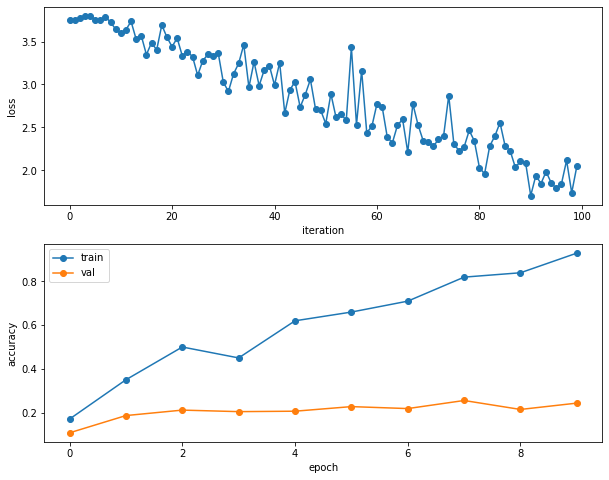

In [40]:
plt.subplot(2, 1, 1)
plt.plot(loss_history, '-o')
plt.xlabel('iteration')
plt.ylabel('loss')

plt.subplot(2, 1, 2)
plt.plot(train_accuracy_history, '-o')
plt.plot(val_accuracy_history, '-o')
plt.legend(['train', 'val'], loc='upper left')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

<font size="3">Entraînement complet</font>

- Entraînez votre réseau pour 3 epochs.  Vous devriez avoir une justesse en validation d'**au moins 48\%** lorsqu'entraîné sur 6,000 données.
- Par la suite, entraînez votre réseau pour 1 autre epoch mais sur **100% des données**.  Vous devriez avoir une justesse en validation d'**au moins 58\%**.

In [41]:
from model.Solver import epoch_solver, Adam

reg = 1e-2 # à ajuster au besoin
lr = 5e-4  # à ajuster au besoin
model = create_Nlayer_cnn(32, 16, 400, reg)

optimizer = Adam(lr, model)

# change back to full X_train y_train for complete dataset
loss_history, train_accuracy_history, val_accuracy_history = epoch_solver(X_train[:6000], 
                                                                          y_train[:6000],
                                                                          X_val,
                                                                          y_val,
                                                                          reg,
                                                                          optimizer,
                                                                          batch_size=100,
                                                                          epochs=3)

(batch 20 / 60) loss: 2.991708
(batch 40 / 60) loss: 2.438914
(batch 60 / 60) loss: 2.079484
(epoch 1 / 3) loss: 2.079484, train_acc: 0.419833, val_acc: 0.404000
(batch 20 / 60) loss: 1.948044
(batch 40 / 60) loss: 1.796636
(batch 60 / 60) loss: 1.653697
(epoch 2 / 3) loss: 1.653697, train_acc: 0.393667, val_acc: 0.350000
(batch 20 / 60) loss: 1.633985
(batch 40 / 60) loss: 1.471108
(batch 60 / 60) loss: 1.468921
(epoch 3 / 3) loss: 1.468921, train_acc: 0.537500, val_acc: 0.502000


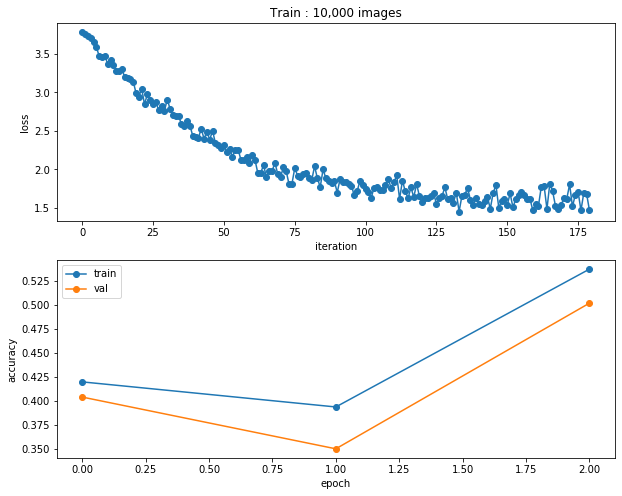

In [42]:
plt.subplot(2, 1, 1)
plt.plot(loss_history, '-o')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.title('Train : 10,000 images')

plt.subplot(2, 1, 2)
plt.plot(train_accuracy_history, '-o')
plt.plot(val_accuracy_history, '-o')
plt.legend(['train', 'val'], loc='upper left')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

In [43]:
# On réentraîne (1 epoch) avec 100% des données d'entraînement.
loss_history, train_accuracy_history, val_accuracy_history = epoch_solver(X_train, 
                                                                          y_train,
                                                                          X_val,
                                                                          y_val,
                                                                          reg,
                                                                          optimizer,
                                                                          batch_size=100,
                                                                          epochs=1)

(batch 20 / 490) loss: 1.571332
(batch 40 / 490) loss: 1.508978
(batch 60 / 490) loss: 1.498346
(batch 80 / 490) loss: 1.641021
(batch 100 / 490) loss: 1.557358
(batch 120 / 490) loss: 1.514617
(batch 140 / 490) loss: 1.447617
(batch 160 / 490) loss: 1.353024
(batch 180 / 490) loss: 1.453173
(batch 200 / 490) loss: 1.461930
(batch 220 / 490) loss: 1.434813
(batch 240 / 490) loss: 1.425764
(batch 260 / 490) loss: 1.423091
(batch 280 / 490) loss: 1.475312
(batch 300 / 490) loss: 1.536417
(batch 320 / 490) loss: 1.498751
(batch 340 / 490) loss: 1.490579
(batch 360 / 490) loss: 1.357693
(batch 380 / 490) loss: 1.468340
(batch 400 / 490) loss: 1.370839
(batch 420 / 490) loss: 1.416575
(batch 440 / 490) loss: 1.566708
(batch 460 / 490) loss: 1.539342
(batch 480 / 490) loss: 1.528865
(epoch 1 / 1) loss: 1.423512, train_acc: 0.584898, val_acc: 0.586000


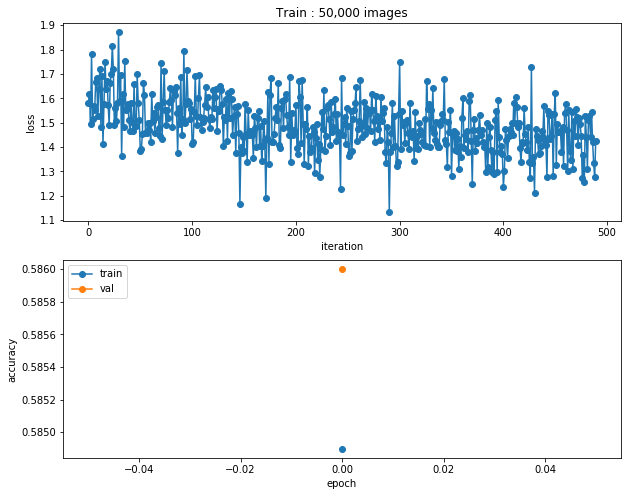

In [44]:
plt.subplot(2, 1, 1)
plt.plot(loss_history, '-o')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.title('Train : 50,000 images')

plt.subplot(2, 1, 2)
plt.plot(train_accuracy_history, '-o')
plt.plot(val_accuracy_history, '-o')
plt.legend(['train', 'val'], loc='upper left')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

## Visualisation des filtres
Vous pouvez visualiser les filtres de la première couche du réseau entraîné :

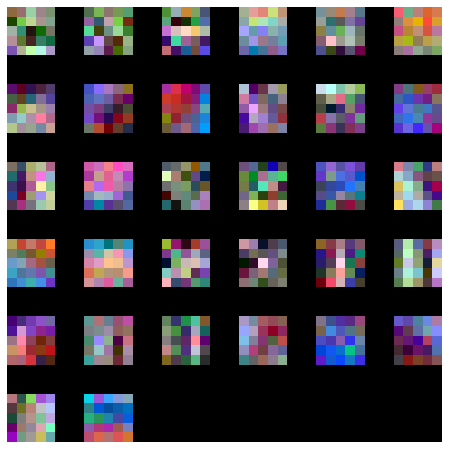

In [45]:
from visualization.utils import visualize_as_grid

def show_net_weights(model):
    W1 = model.parameters()['L0']['W']
    W1 = W1.transpose(0, 2, 3, 1)
    plt.imshow(visualize_as_grid(W1, padding=3).astype('uint8'))
    plt.gca().axis('off')
    plt.show()

show_net_weights(model)